In [1]:
import scvelo as scv
import scanpy as sc
import os 
from pathlib import Path
import numpy as np 
import pandas as pd 
from anndata import AnnData

In [3]:
import sys  
sys.path.insert(1,'/home/sergio/Jnotebooks/SALMON/github_repo/SALMON/stvelo/')
from pipelines.metrics import *

In [2]:
notebook_dir = os.getcwd()
notebook_dir

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\STVelo\\notebooks\\metrics'

In [5]:
Path(notebook_dir).parents[2]

PosixPath('/home/sergio/Jnotebooks/SALMON/github_repo')

In [6]:
os.chdir(Path(notebook_dir).parents[2])

In [7]:
saving_path='/home/sergio/Jnotebooks/SALMON/datasets/simulated_data/'

In [8]:
files=os.listdir(saving_path)
adata_dict={}
for f in files:
    adata_dict[f.split('.')[0]]=sc.read(os.path.join(saving_path,f))

In [9]:
adata_dict.keys()

dict_keys(['adata_s_u_deterministic', 'adata_s_u_dynamical', 'adata_n_c_dynamical', 'adata_n_c_stochastic', 'adata_s_u_stochastic', 'adata_n_c_deterministic'])

# Metrics - Between Models 

In [12]:
# While working on anndata object as a values of a dictionary, anndata_dict.copy() doesn't prevent changement in the original dict.
# Followed line does.
alldata_norm = {key: adata.copy() for key, adata in adata_dict.items()}

## MSE on Fit U/S counts VS real U/S counts

In [36]:
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
from scvelo.plotting.simulation import compute_dynamics
def get_fit_scvelo(adata):
    """
    Compute spliced and unspliced RNA velocity fits for each gene in an AnnData object.

    Parameters:
    -----------
    adata : AnnData
        Annotated data matrix of shape `n_obs` x `n_vars` (cells x genes), 
        typically used in scRNA-seq analysis. It must contain precomputed 
        layers "Ms" (spliced) and "Mu" (unspliced) matrices, representing 
        the spliced and unspliced transcript counts.

    Returns:
    --------
    scvelo_fit_s : pd.DataFrame
        DataFrame containing the computed spliced fits for each gene 
        across cells. Rows represent cells, and columns represent genes.
    
    scvelo_fit_u : pd.DataFrame
        DataFrame containing the computed unspliced fits for each gene 
        across cells. Rows represent cells, and columns represent genes.

    Description:
    ------------
    The function iterates through the genes in the `adata` object and computes 
    the RNA velocity fits (both spliced and unspliced) for each gene using the 
    `compute_dynamics` function. It stores the results in two DataFrames: one 
    for spliced RNA counts and one for unspliced RNA counts.
    """
    # Initialize DataFrames with zeros, having the same shape as "Ms" and "Mu" layers.
    scvelo_fit_s = pd.DataFrame(
        np.zeros_like(adata.layers["Ms"]),
        index=adata.obs_names,
        columns=adata.var_names,
    )
    scvelo_fit_u = pd.DataFrame(
        np.zeros_like(adata.layers["Mu"]),
        index=adata.obs_names,
        columns=adata.var_names,
    )

    # Iterate through each gene, compute its RNA velocity dynamics, and store the fits.
    for i, g in tqdm(enumerate(adata.var_names)):
        _, ut, st = compute_dynamics(
            adata,
            basis=adata.var_names[i],
            key="fit",
            extrapolate=False,
            sort=False,
            t=None,
        )
        # Store spliced and unspliced fits in the respective DataFrames
        scvelo_fit_s[g] = st
        scvelo_fit_u[g] = ut
    
    return scvelo_fit_s, scvelo_fit_u


### mse with codes from velovi reproducibility

- In our case not that helpful because two approach uses different counts. 
- But it can be still used to compare different models on the chosen approach in terms of spliced-unspliced or nucleic-cythoplasmic.
- **Can be written in more useful way: make the function takes the list of adatas, then drive required info the function itself!**

In [38]:
def compute_mse(ms, mu, mn, mc, fit_s, fit_u, fit_n, fit_c):
    """
    Compute the Mean Squared Error (MSE) between actual and fitted values 
    for different RNA layers (spliced, unspliced, nuclear, and cytoplasmic) 
    and return the log10 MSE ratio.

    Parameters:
    -----------
    ms : np.ndarray
        Observed spliced RNA values.
    mu : np.ndarray
        Observed unspliced RNA values.
    mn : np.ndarray
        Observed nuclear RNA values.
    mc : np.ndarray
        Observed cytoplasmic RNA values.
    fit_s : np.ndarray
        Fitted spliced RNA values.
    fit_u : np.ndarray
        Fitted unspliced RNA values.
    fit_n : np.ndarray
        Fitted nuclear RNA values.
    fit_c : np.ndarray
        Fitted cytoplasmic RNA values.
    Returns:
    --------
    mse_df : pd.DataFrame
        DataFrame containing the log10 MSE ratios for spliced vs nuclear 
        and unspliced vs cytoplasmic RNA, along with the corresponding feature labels.
    """
    # Compute Mean Squared Error (MSE) for spliced, unspliced, nuclear, and cytoplasmic values.
    mse_s = np.mean((fit_s - ms) ** 2, axis=0)
    mse_u = np.mean((fit_u - mu) ** 2, axis=0)
    mse_n = np.mean((fit_n - mn) ** 2, axis=0)
    mse_c = np.mean((fit_c - mc) ** 2, axis=0)

    # Create a DataFrame to store MSE results and log10 ratios.
    mse_df = pd.DataFrame()
    
    # Calculate log10 ratios for spliced/nuclear and unspliced/cytoplasmic MSE.
    sn = np.log10(mse_s / mse_n)
    uc = np.log10(mse_u / mse_c)

    # Add the log10 MSE ratios and feature labels to the DataFrame.
    mse_df["log10 MSE ratio"] = np.concatenate([sn, uc]).ravel()
    mse_df["Feature"] = ["spl-nuc"] * len(sn) + ["uns-cyt"] * len(uc)

    return mse_df


In [22]:
# compute mse_1
def compute_mse(ms, mu, mn, mc, fit_s, fit_u, fit_n, fit_c):
    mse_s = np.mean((fit_s - ms) ** 2, axis=0)
    mse_u = np.mean((fit_u - mu) ** 2, axis=0)
    mse_n = np.mean((fit_n - mn) ** 2, axis=0)
    mse_c = np.mean((fit_c - mc) ** 2, axis=0)

    mse_df = pd.DataFrame()
    sn = np.log10(mse_s / mse_n)
    uc = np.log10(mse_u / mse_c)

    mse_df["log10 MSE ratio"] = np.concatenate([sn, uc]).ravel()
    mse_df["Feature"] = ["spl-nuc"] * len(sn) + ["uns-cyt"] * len(uc)
    return mse_df

In [13]:
adata_dict.keys()
adata_s_u=adata_dict['adata_s_u_dynamical']
adata_n_c=adata_dict['adata_n_c_dynamical']

In [14]:
fit_s, fit_u = get_fit_scvelo(adata_s_u)
fit_n, fit_c = get_fit_scvelo(adata_n_c)

ms = adata_s_u.to_df("Ms")
mu = adata_s_u.to_df("Mu")
mn = adata_n_c.to_df("Ms")
mc = adata_n_c.to_df("Mu")

mse_s = np.mean((fit_s - ms) ** 2, axis=0)
mse_u = np.mean((fit_u - mu) ** 2, axis=0)
mse_n = np.mean((fit_n - mn) ** 2, axis=0)
mse_c = np.mean((fit_c - mc) ** 2, axis=0)

mse_df = compute_mse(ms,mu,mn,mc,fit_s,fit_u,fit_n,fit_c)

300it [00:00, 630.41it/s]
300it [00:00, 621.64it/s]


In [69]:
mse_df

,log10 MSE ratio,Feature
0,2.429509,spl-nuc
1,0.534669,spl-nuc
2,0.961144,spl-nuc
3,1.638348,spl-nuc
4,0.728006,spl-nuc
...,...,...
594,-1.271711,uns-cyt
595,-1.586311,uns-cyt
597,-2.134360,uns-cyt
598,-2.473209,uns-cyt


In [64]:
mse_df=mse_df[~mse_df.iloc[:,0].isna()]

<Axes: xlabel='log10 MSE ratio', ylabel='Feature'>

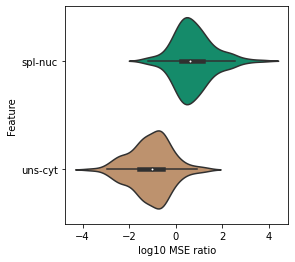

In [68]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.violinplot(
        data=mse_df,
        orient="h",
        ax=ax,
        x="log10 MSE ratio",
        y="Feature",
        palette=["#029e73", "#ca9161"],
    )

### Mse by gene
 - 'axis=0'

In [15]:
def compute_mse_gene(adata):
    """
    s_n stands for moment of spliced or nucleic RNA abundance.
    u_c stands for moment of unspliced or cytoplasmic RNA abundance.

    Parameters
    ----------
    adata : adata object
            'Ms' and 'Mu' should be in adata.layers 

    Returns

            
    """
    s_n = adata.to_df("Ms")
    u_c = adata.to_df("Mu")

    fit_s_n, fit_u_c = get_fit_scvelo(adata)

    mse_s_n = np.mean((fit_s_n - s_n) ** 2, axis=0)
    mse_u_c = np.mean((fit_u_c - u_c) ** 2, axis=0)  
    sum_mse = mse_s_n + mse_u_c    

    return mse_s_n, mse_u_c, sum_mse

In [16]:
mse_gene_df = pd.DataFrame(columns=['Method', 'mse_s_n', 'mse_u_c', 'sum_mse'])

for key, adata in adata_dict.items():
    mse_s_n, mse_u_c, sum_mse = compute_mse_gene(adata)
    
    temp_df = pd.DataFrame({
        'Method': [key] * len(mse_s_n),
        'mse_s_n': mse_s_n,
        'mse_u_c': mse_u_c,
        'sum_mse': sum_mse
    })
    

    mse_gene_df = pd.concat([mse_gene_df, temp_df], ignore_index=True)

300it [00:00, 525.59it/s]
300it [00:00, 337.64it/s]


In [20]:
adata_s_u.var.true_t_

0       2.037712
1       3.281254
2      15.517592
3      12.165593
4      14.566314
         ...    
295    12.513097
296     5.975331
297     8.582472
298     6.004733
299     7.316382
Name: true_t_, Length: 300, dtype: float64

In [17]:
time_gene_dict = dict(zip(adata_s_u.var.index,adata_s_u.var.true_t_))

In [ ]:
mse_gene_df['gene_index'] = mse_gene_df.groupby('Method').cumcount()

In [24]:
mse_gene_df['time'] = mse_gene_df['gene_index'].map(time_gene_dict)

In [21]:
mse_gene_df['gene_index'] = mse_gene_df['gene_index'].astype(str)

In [25]:
mse_gene_df

,Method,mse_s_n,mse_u_c,sum_mse,gene_index,time
0,adata_n_c,0.000645,0.036209,0.036854,0,2.037712
1,adata_n_c,0.108215,0.088575,0.196789,1,3.281254
2,adata_n_c,0.012037,0.025797,0.037834,2,15.517592
3,adata_n_c,0.362021,0.168038,0.530059,3,12.165593
4,adata_n_c,488.681912,49.672194,538.354106,4,14.566314
...,...,...,...,...,...,...
595,adata_s_u,0.001384,0.003163,0.004547,295,12.513097
596,adata_s_u,NaN,NaN,NaN,296,5.975331
597,adata_s_u,NaN,NaN,NaN,297,8.582472
598,adata_s_u,22.626240,0.386246,23.012486,298,6.004733


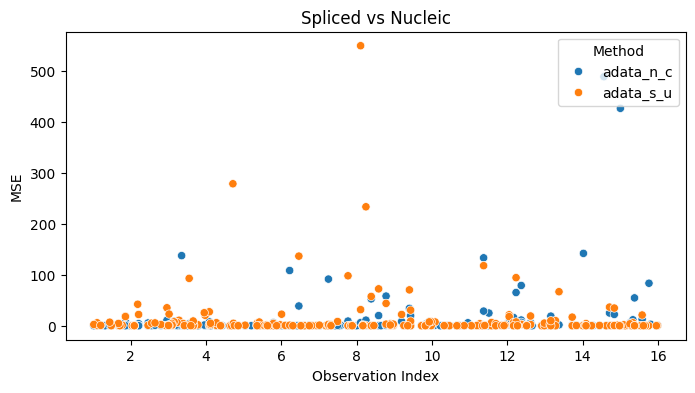

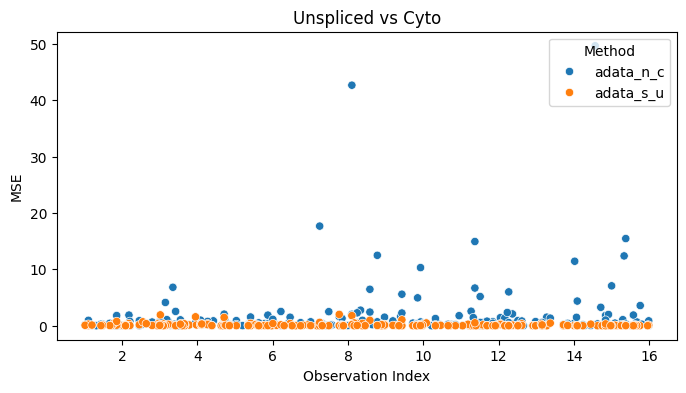

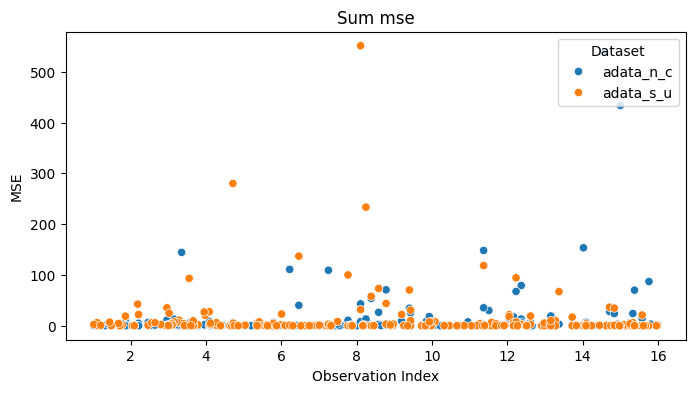

In [26]:
# mse_gene_df['gene_index'] = mse_gene_df.groupby('Method').cumcount()
# mse_gene_df['time'] = mse_gene_df.groupby('Method').cumcount()

# Initialize the plot for mse_s_n
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_gene_df, x='time', y='mse_s_n', hue='Method')
plt.xlabel('Observation Index')
plt.ylabel('MSE')
plt.title('Spliced vs Nucleic')
plt.legend(title='Method', loc='upper right')
plt.show()

# Initialize the plot for mse_u_c
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_gene_df, x='time', y='mse_u_c', hue='Method')
plt.xlabel('Observation Index')
plt.ylabel('MSE')
plt.title('Unspliced vs Cyto')
plt.legend(title='Method', loc='upper right')
plt.show()

# Initialize the plot for sum_mse
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_gene_df, x='time', y='sum_mse', hue='Method')
plt.xlabel('Observation Index')
plt.ylabel('MSE')
plt.title('Sum mse')
plt.legend(title='Dataset', loc='upper right')
plt.show()


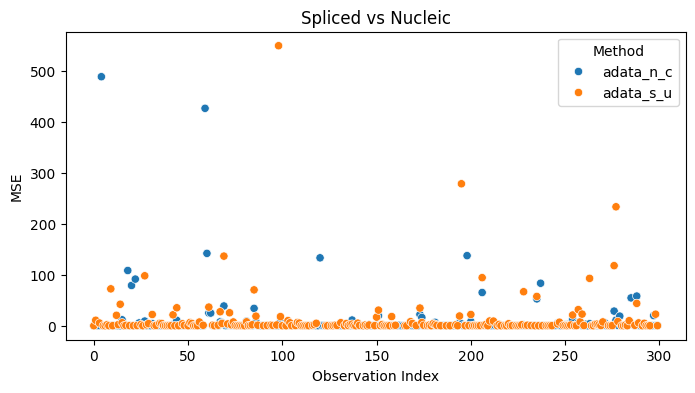

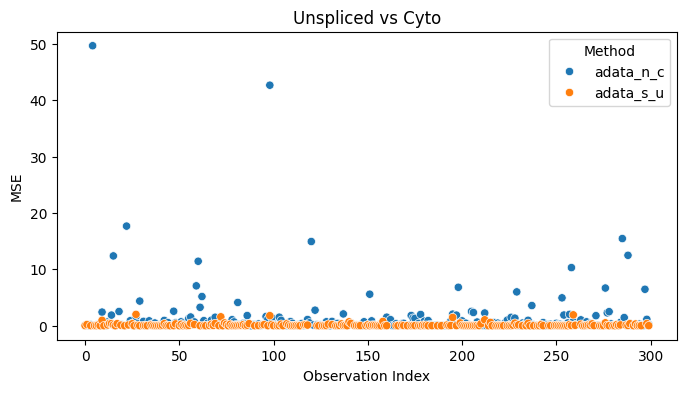

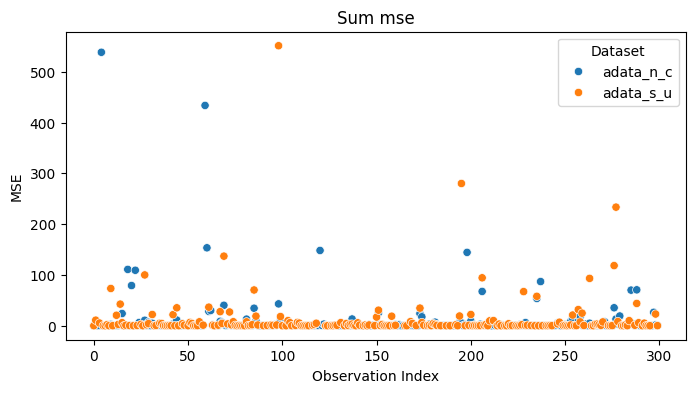

In [27]:
mse_gene_df['gene_index'] = mse_gene_df.groupby('Method').cumcount()


# Initialize the plot for mse_s_n
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_gene_df, x='gene_index', y='mse_s_n', hue='Method')
plt.xlabel('Observation Index')
plt.ylabel('MSE')
plt.title('Spliced vs Nucleic')
plt.legend(title='Method', loc='upper right')
plt.show()

# Initialize the plot for mse_u_c
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_gene_df, x='gene_index', y='mse_u_c', hue='Method')
plt.xlabel('Observation Index')
plt.ylabel('MSE')
plt.title('Unspliced vs Cyto')
plt.legend(title='Method', loc='upper right')
plt.show()

# Initialize the plot for sum_mse
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_gene_df, x='gene_index', y='sum_mse', hue='Method')
plt.xlabel('Observation Index')
plt.ylabel('MSE')
plt.title('Sum mse')
plt.legend(title='Dataset', loc='upper right')
plt.show()


In [30]:
adata_s_u.var

,true_t_,true_alpha,true_beta,true_nu,true_gamma,true_scaling,n_cells,fit_r2,fit_alpha,fit_beta,...,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling,velocity_genes
0,2.037712,1.986205,0.913912,2.312691,5.913475,1.0,533,0.866849,0.208736,0.117985,...,0.212650,0.538970,0.0,0.0,0.470461,1.715987,0.769775,0.043046,3.888839,True
1,3.281254,14.352041,19.595564,5.787095,4.270037,1.0,483,0.894760,2.994817,4.163006,...,1.897021,1.363917,0.0,0.0,0.480775,0.734380,5.574400,0.019571,1.751979,True
2,15.517592,0.384659,0.344917,0.598932,0.350859,1.0,780,-0.040219,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,12.165593,8.987051,16.881849,2.151419,1.750226,1.0,676,0.831906,6.421468,12.614544,...,3.944782,1.173413,0.0,0.0,0.460147,0.540613,9.327514,0.079005,1.290843,True
4,14.566314,184.481835,94.278825,2.702010,0.999819,1.0,714,0.686389,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,12.513097,6.944716,2.665581,5.781729,8.045860,1.0,697,0.971952,1.741052,0.647302,...,0.893994,5.115296,0.0,0.0,0.304309,2.684979,2.090601,0.002199,1.198340,True
296,5.975331,0.132156,0.032239,0.053607,0.031424,1.0,740,-1.706594,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
297,8.582472,6.306617,1.734552,0.343778,0.047353,1.0,723,-0.488854,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
298,6.004733,9.514889,3.926554,0.832762,1.815340,1.0,591,0.677641,5.648335,2.159789,...,5.878516,2.144088,0.0,0.0,0.494804,2.463080,15.705366,0.012067,2.659890,True


In [28]:
adata_s_u.var.fit_alpha.isna().sum()

72

In [44]:
adata_n_c.var.fit_alpha.isna().sum()

0

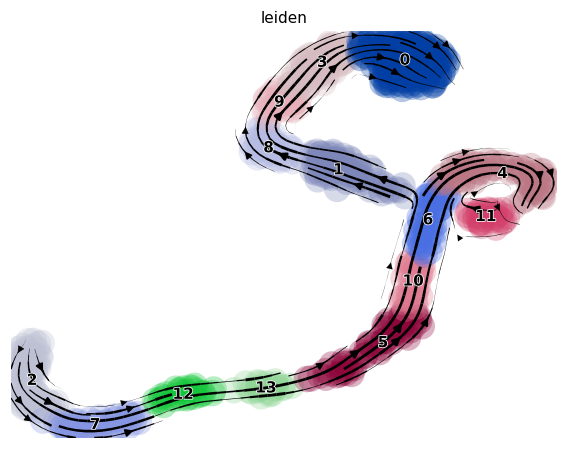

In [31]:
scv.pl.velocity_embedding_stream(adata_s_u, basis='umap',color="leiden", dpi=110)

In [32]:
adata_n_c

AnnData object with n_obs × n_vars = 800 × 300
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_r2', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'nucleic', 'spliced', 'spliced_cyto', 'spliced_nuc', 'unspliced', 'fit_t', 'fit_tau', 'fit_tau_', 'Ms', 'Mu', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

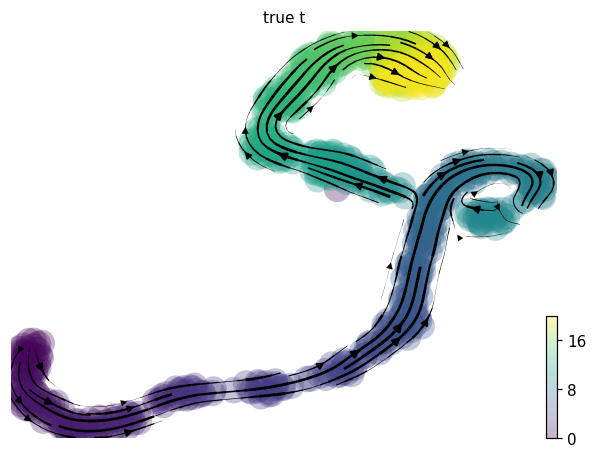

In [33]:
scv.pl.velocity_embedding_stream(adata_s_u, basis='umap',color="true_t", dpi=110)

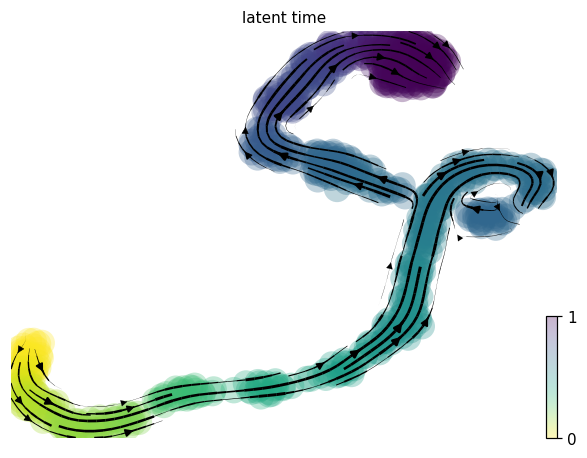

In [36]:
scv.pl.velocity_embedding_stream(adata_s_u, basis='umap',color="latent_time", dpi=110)

In [34]:
mse_gene_df[mse_gene_df['gene_index']==123]

,Method,mse_s_n,mse_u_c,sum_mse,gene_index
123,adata_n_c,86.138257,72.828025,158.966282,123
373,adata_s_u,2.079691,0.085950,2.165641,123


In [31]:
adata_n_c

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'nucleic', 'spliced', 'spliced_cyto', 'spliced_nuc', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [35]:
scv.tl.latent_time(adata_n_c)
scv.tl.latent_time(adata_s_u)

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [ ]:
import warnings

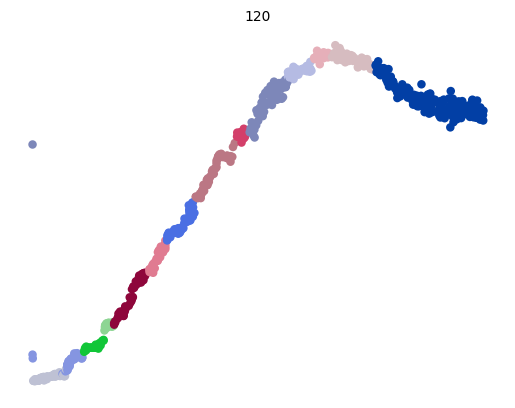

In [55]:
var_names = ['23']
scv.pl.scatter(adata_n_c, x='true_t', y='120',color="leiden", frameon=False)

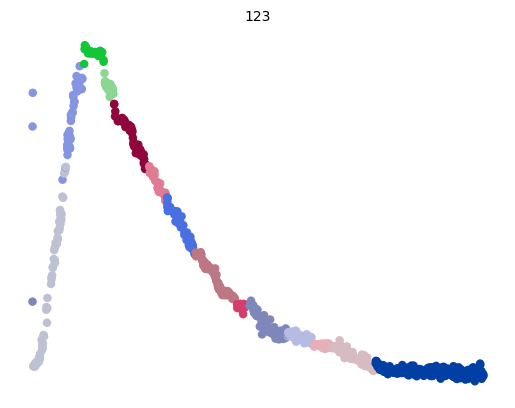

In [39]:
scv.pl.scatter(adata_s_u, x='true_t', y='123',color="leiden", frameon=False)

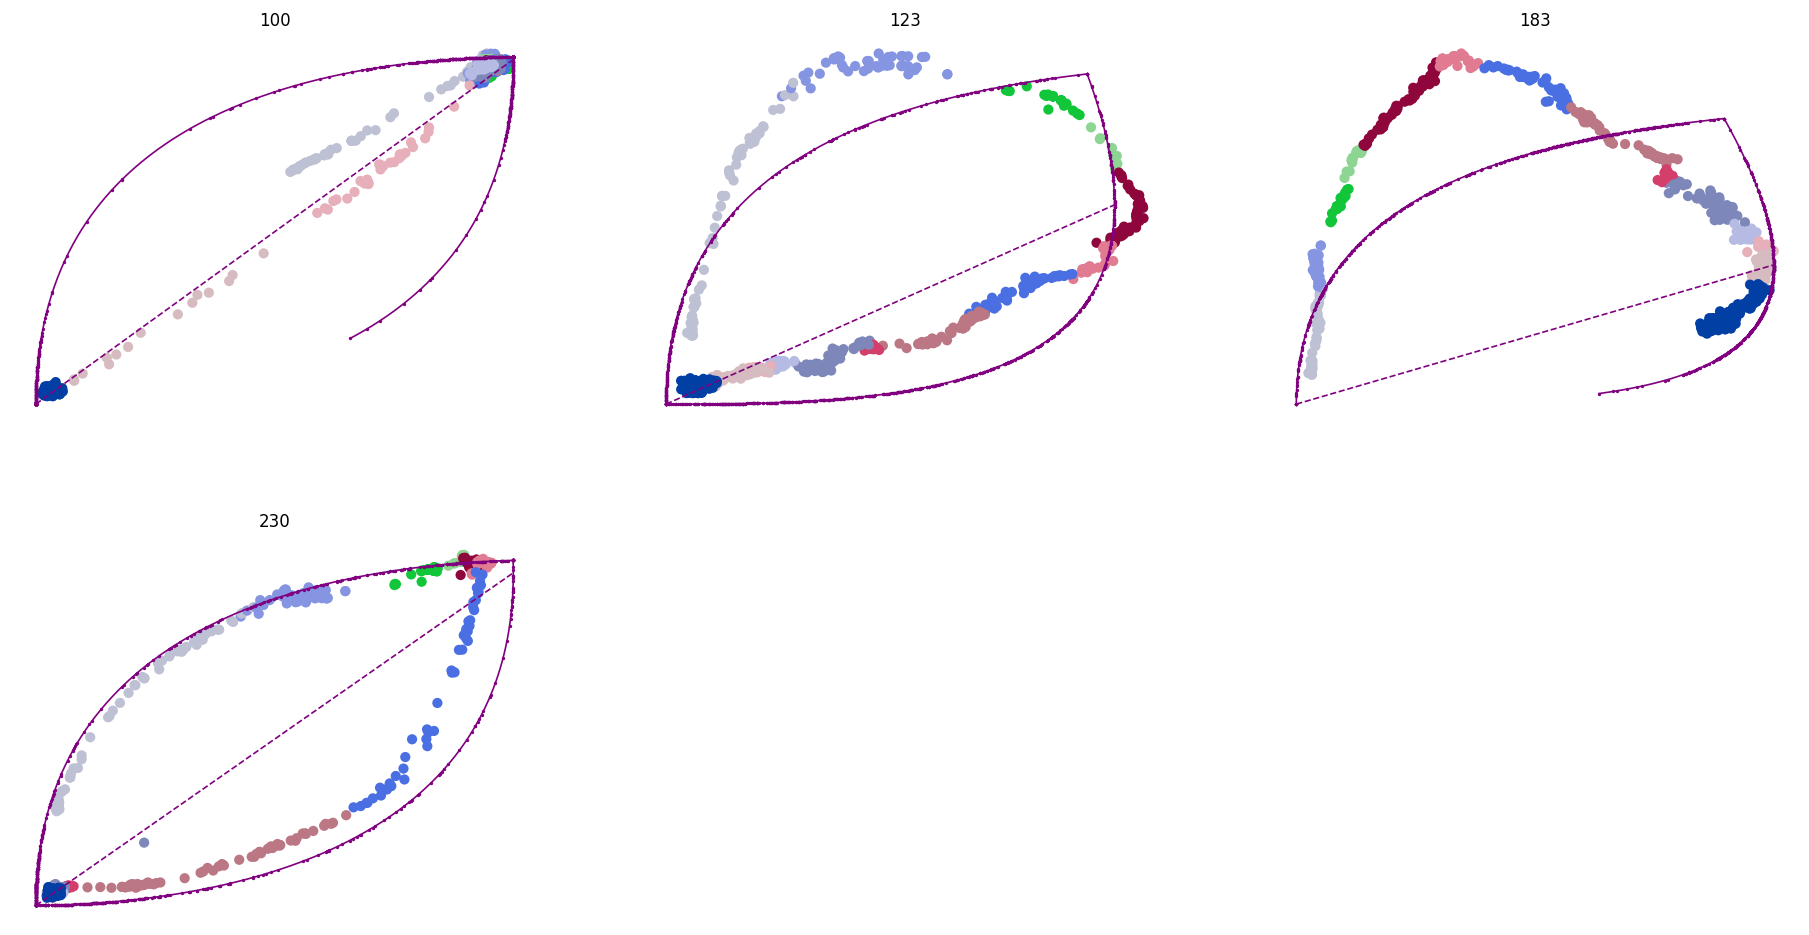

In [40]:
scv.pl.scatter(adata_n_c,color="leiden", basis=['100','123','183','230'], ncols=3, frameon=False,dpi=120)

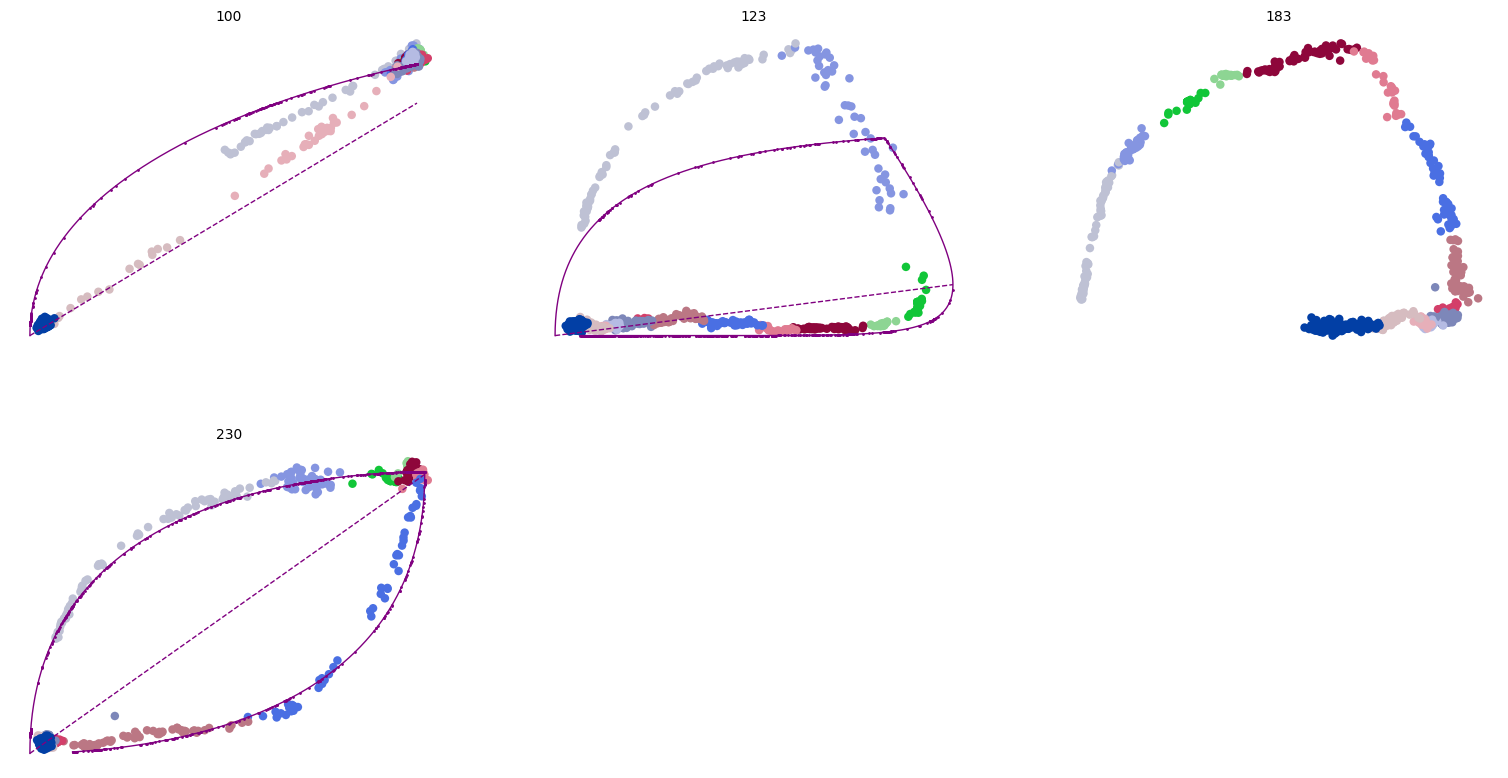

In [41]:
scv.pl.scatter(adata_s_u,color="leiden", basis=['100','123','183','230'], ncols=3, frameon=False,dpi=100)

### mse cell


In [58]:
def compute_mse_cell(adata):
    """
    s_n stands for moment of spliced or nucleic RNA abundance.
    u_c stands for moment of unspliced or cytoplasmic RNA abundance.
      """
    s_n = adata.to_df("Ms")
    u_c = adata.to_df("Mu")

    fit_s_n, fit_u_c = get_fit_scvelo(adata)

    mse_s_n = np.mean((fit_s_n - s_n) ** 2, axis=1)
    mse_u_c = np.mean((fit_u_c - u_c) ** 2, axis=1)  
    sum_mse = mse_s_n + mse_u_c    

    return mse_s_n, mse_u_c, sum_mse

In [59]:
mse_cell_df = pd.DataFrame(columns=['Method', 'mse_s_n', 'mse_u_c', 'sum_mse'])

for key, adata in adata_dict.items():
    mse_s_n, mse_u_c, sum_mse = compute_mse_cell(adata)
    
    temp_df = pd.DataFrame({
        'Method': [key] * len(mse_s_n),
        'mse_s_n': mse_s_n,
        'mse_u_c': mse_u_c,
        'sum_mse': sum_mse
    })
    

    mse_cell_df = pd.concat([mse_cell_df, temp_df], ignore_index=True)

300it [00:00, 923.09it/s]
300it [00:00, 663.85it/s]


In [60]:
mse_cell_df

,Method,mse_s_n,mse_u_c,sum_mse
0,adata_n_c,203.014093,87.820537,290.834631
1,adata_n_c,401.938765,65.198053,467.136818
2,adata_n_c,250.447885,82.355434,332.803319
3,adata_n_c,16.123695,16.185688,32.309383
4,adata_n_c,11.630006,10.075571,21.705576
...,...,...,...,...
1595,adata_s_u,25.713472,0.149732,25.863204
1596,adata_s_u,22.919389,0.147238,23.066627
1597,adata_s_u,26.674799,0.219854,26.894653
1598,adata_s_u,25.945931,0.179417,26.125348


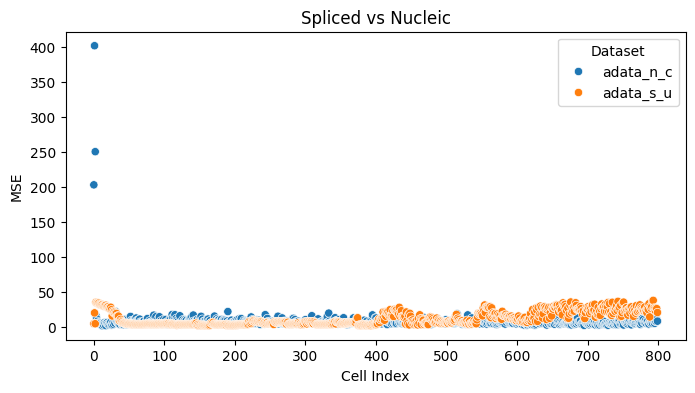

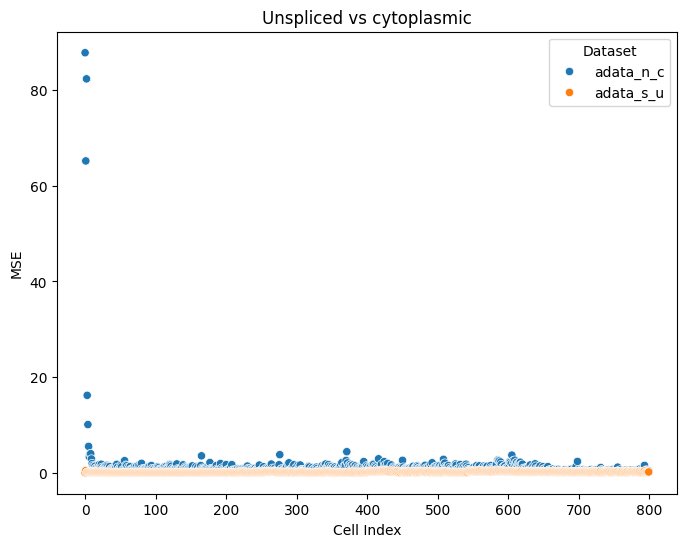

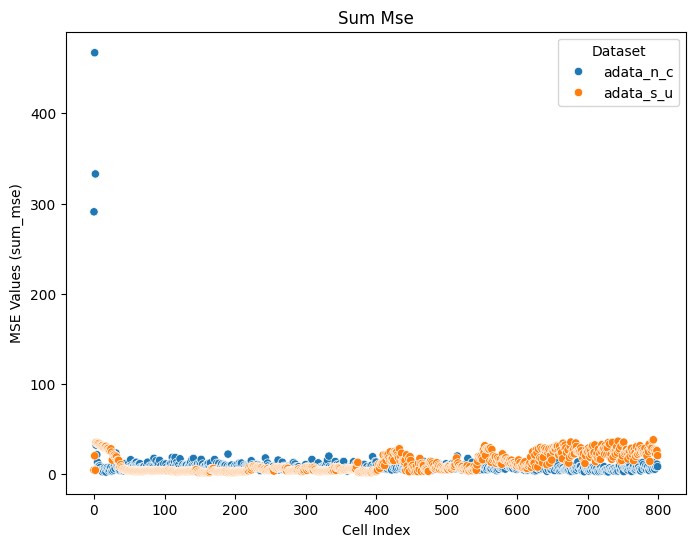

In [61]:

# Create an observation index for each unique observation (0 to 599)
mse_cell_df['cell_index'] = mse_cell_df.groupby('Method').cumcount()


# Initialize the plot for mse_s_n
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_cell_df, x='cell_index', y='mse_s_n', hue='Method')
plt.xlabel('Cell Index')
plt.ylabel('MSE')
plt.title('Spliced vs Nucleic')
plt.legend(title='Dataset', loc='upper right')
plt.show()

# Initialize the plot for mse_u_c
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mse_cell_df, x='cell_index', y='mse_u_c', hue='Method')
plt.xlabel('Cell Index')
plt.ylabel('MSE')
plt.title('Unspliced vs cytoplasmic')
plt.legend(title='Dataset', loc='upper right')
plt.show()

# Initialize the plot for sum_mse
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mse_cell_df, x='cell_index', y='sum_mse', hue='Method')
plt.xlabel('Cell Index')
plt.ylabel('MSE Values (sum_mse)')
plt.title('Sum Mse')
plt.legend(title='Dataset', loc='upper right')
plt.show()


In [65]:
mse_cell_df[mse_cell_df['sum_mse']>30]

,Method,mse_s_n,mse_u_c,sum_mse,cell_index
0,adata_n_c,203.014093,87.820537,290.834631,0
1,adata_n_c,401.938765,65.198053,467.136818,1
2,adata_n_c,250.447885,82.355434,332.803319,2
3,adata_n_c,16.123695,16.185688,32.309383,3
803,adata_s_u,35.005429,0.150608,35.156037,3
804,adata_s_u,34.087116,0.157156,34.244272,4
805,adata_s_u,34.238344,0.157608,34.395953,5
806,adata_s_u,33.659091,0.153262,33.812353,6
807,adata_s_u,33.978494,0.157000,34.135494,7
808,adata_s_u,32.561731,0.143664,32.705394,8


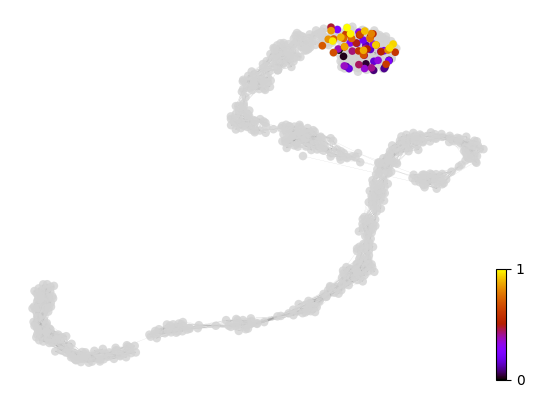

In [69]:
x, y = scv.utils.get_cell_transitions(adata_n_c, basis='umap', starting_cell=700)
ax = scv.pl.velocity_graph(adata_n_c, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

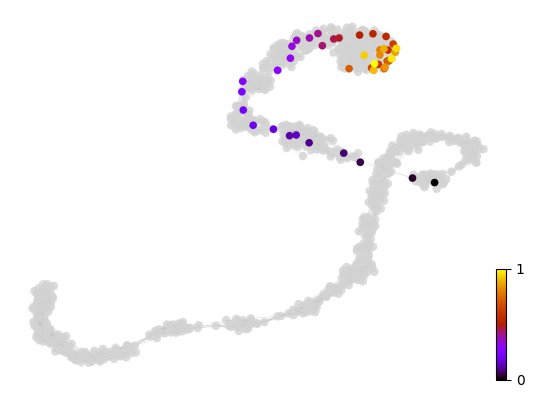

In [72]:
x, y = scv.utils.get_cell_transitions(adata_s_u, basis='umap', starting_cell=400)
ax = scv.pl.velocity_graph(adata_s_u, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

In [ ]:
# check the values by gene with mse values
# compare by cell 

<Axes: xlabel='sum_mse'>

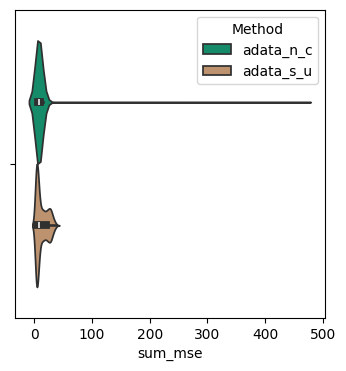

In [73]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.violinplot(
        data=mse_cell_df,
        orient="h",
        ax=ax,
        x="sum_mse",
        hue="Method",
        palette=["#029e73", "#ca9161"],
    )

# Inference Comparison 

In [74]:
adatas_dict = np.load('data/simulated/data_dict_with_velocity_det_dyn_3ode.npy',allow_pickle='TRUE').item()

In [75]:
adatas_dict.keys()

dict_keys(['adata_n_c_det', 'adata_s_u_det', 'adata_n_c_dyn', 'adata_s_u_dyn'])

In [ ]:
adata_dict

In [14]:
adatas_dict['adata_n_c_det'].layers['velocity'].shape

(600, 250)

In [77]:
adata_n_c.var['true_beta'].shape

(300,)

In [59]:
adatas_dict['adata_n_c_dyn'].var.true_beta

0      0.6
1      0.6
2      0.6
3      0.6
4      0.6
      ... 
245    0.6
246    0.6
247    0.6
248    0.6
249    0.6
Name: true_beta, Length: 250, dtype: float64

In [98]:
from scipy.stats import pearsonr

# correlation_df = pd.DataFrame(columns=['correlation', 'method', 'n_obs', 'run'])
correlation_df = pd.DataFrame(columns=['correlation', 'method'])

for key, value in adatas_dict.items():
    adata = value
    adata.var['true_ratio'] = np.array(adata.var.true_gamma / adata.var.true_beta)

    # Deterministic Model 
    if 'velocity_gamma' in adata.var.keys():
        adata.var['steady_state_ratio'] = adata.var['velocity_gamma']
        corr = pearsonr(adata.var['true_ratio'], adata.var['steady_state_ratio'])[0]

        temp_df = pd.DataFrame({
        'correlation': corr,
        'method': [key] 
          })
        correlation_df = pd.concat([correlation_df, temp_df], ignore_index=True)

    # Dynamical Model (EM)
    else:
        adata.var['em_ratio'] = adata.var['fit_gamma'] / adata.var['fit_beta']
        corr = pearsonr(adata.var['true_ratio'], adata.var['em_ratio'])[0]

        temp_df = pd.DataFrame({
        'correlation': corr,
        'method': [key] 
          })

        correlation_df = pd.concat([correlation_df, temp_df], ignore_index=True)



0.6006265078570338
0.7121707165390643


In [99]:
correlation_df

,correlation,method
0,0.600627,adata_n_c_det
1,0.712171,adata_s_u_det
2,0.664963,adata_n_c_dyn
3,0.752818,adata_s_u_dyn


In [93]:
a = adatas_dict['adata_s_u_dyn']

In [94]:
a.var

,true_t_,true_alpha,true_beta,true_nu,true_gamma,true_scaling,n_cells,fit_r2,fit_alpha,fit_beta,...,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling,velocity_genes,true_ratio,em_ratio
0,2.037712,1.986205,0.913912,2.312691,5.913475,1.0,533,0.866849,0.208736,0.117985,...,0.0,0.0,0.470461,1.715987,0.769775,0.043046,3.888839,True,6.470505,1.588206
1,3.281254,14.352041,19.595564,5.787095,4.270037,1.0,483,0.894760,2.994817,4.163006,...,0.0,0.0,0.480775,0.734380,5.574400,0.019571,1.751979,True,0.217908,0.126080
2,15.517592,0.384659,0.344917,0.598932,0.350859,1.0,780,-0.040219,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.017226,NaN
3,12.165593,8.987051,16.881849,2.151419,1.750226,1.0,676,0.831906,6.421468,12.614544,...,0.0,0.0,0.460147,0.540613,9.327514,0.079005,1.290843,True,0.103675,0.055500
4,14.566314,184.481835,94.278825,2.702010,0.999819,1.0,714,0.686389,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.010605,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,12.513097,6.944716,2.665581,5.781729,8.045860,1.0,697,0.971952,1.741052,0.647302,...,0.0,0.0,0.304309,2.684979,2.090601,0.002199,1.198340,True,3.018427,1.251948
296,5.975331,0.132156,0.032239,0.053607,0.031424,1.0,740,-1.706594,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.974725,NaN
297,8.582472,6.306617,1.734552,0.343778,0.047353,1.0,723,-0.488854,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.027300,NaN
298,6.004733,9.514889,3.926554,0.832762,1.815340,1.0,591,0.677641,5.648335,2.159789,...,0.0,0.0,0.494804,2.463080,15.705366,0.012067,2.659890,True,0.462324,0.144262


In [95]:
filtered_adata = a[:, a.var['velocity_genes']==True].copy()

In [97]:
adatas_dict['adata_s_u_dyn'] = filtered_adata

In [96]:
filtered_adata

AnnData object with n_obs × n_vars = 800 × 216
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'true_ratio', 'em_ratio'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'nucleic', 'spliced', 'spliced_cyto', 'spliced_nuc', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [84]:
sns.barplot(
        data=correlation_df,
        x='method',
        y='correlation',
        hue="method",
        ax=ax,
        palette='colorblind')

<Axes: xlabel='sum_mse', ylabel='correlation'>

In [ ]:
adata_n_c = adata_dict["adata_n_c"]
adata_s_u = adata_dict["adata_s_u"]

## Confidence

In [10]:
for d in adata_dict.keys():
    print(d)
    adata_dict[d]=compute_confidence(adata_dict[d])

adata_s_u_deterministic
computing velocity graph (using 2/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

Global seed set to 0
Global seed set to 0


    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
adata_s_u_dynamical
computing velocity graph (using 2/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
adata_n_c_dynamical
computing velocity graph (using 2/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
adata_n_c_stochastic
computing velocity graph (using 2/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
adata_s_u_stochastic
computing velocity graph (using 2/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
adata_n_c_deterministic
computing velocity graph (using 2/32 cores)


  0%|          | 0/799 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [14]:
# Confidence plotting

<Axes: xlabel='Velocity confidence', ylabel='velo_type'>

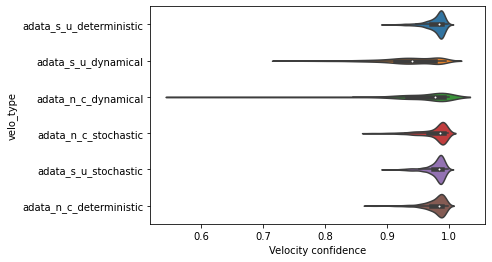

In [15]:
import seaborn as sns
confidences=get_confidences(adata_dict)
sns.violinplot(data=confidences,x='Velocity confidence',y='velo_type')

# Velocity correlation

This function calculates the pairwise velocity correlation matrix between datasets, averaging the correlation coefficients across either genes or cells to assess the similarity in velocity patterns between dataset pairs.

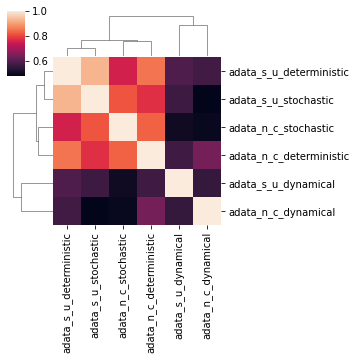

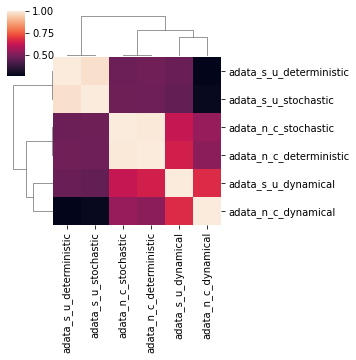

In [16]:
velo_corr_bygene=velocity_mean_correlation(adata_dict,mode='by_gene')
sns.clustermap(velo_corr_bygene.astype(float),figsize=(5,5))
velo_corr_bycell=velocity_mean_correlation(adata_dict,mode='by_cell')
sns.clustermap(velo_corr_bycell.astype(float),figsize=(5,5))

# Velocity correlation against reference run (by gene and by cell)

This metric calculates the correlation between velocity vectors in single-cell data across multiple datasets, either on a per-gene or per-cell basis. It quantifies how similarly the velocities (which represent transcriptional dynamics) behave between a reference dataset and other datasets, providing insight into shared or divergent biological processes.

In [17]:
velocity_correlation_by_gene=velocity_corr_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_gene')
velocity_correlation_by_cell=velocity_corr_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_cell')

Text(0, 0.5, 'Modality')

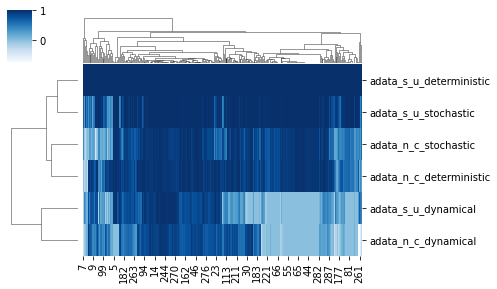

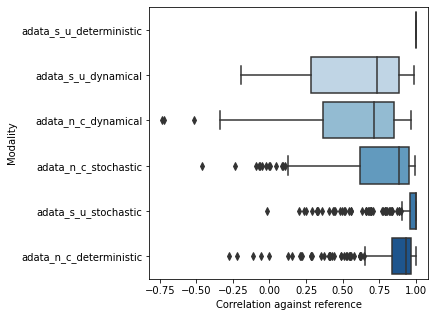

In [18]:
import matplotlib.pyplot as plt
sns.clustermap(velocity_correlation_by_gene.fillna(0),figsize=(7,4),cmap='Blues')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_correlation_by_gene.stack().reset_index(),y='level_0',x=0,palette='Blues')
plt.xlabel('Correlation against reference')
plt.ylabel('Modality')


Text(0.5, 0, 'Correlation against reference')

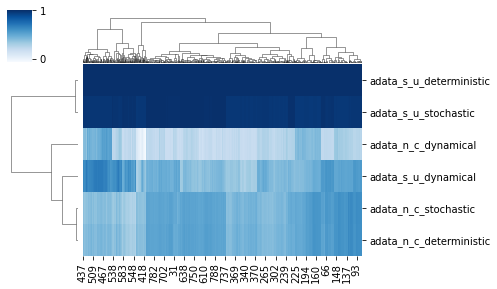

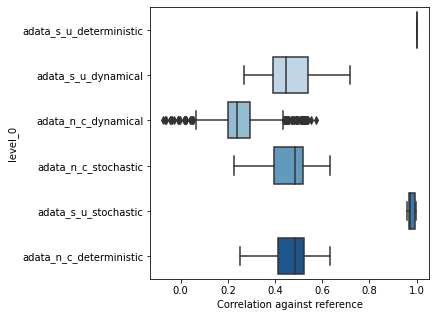

In [19]:
import matplotlib.pyplot as plt
sns.clustermap(velocity_correlation_by_cell.fillna(0),figsize=(7,4),cmap='Blues')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_correlation_by_cell.stack().reset_index(),y='level_0',x=0,palette='Blues')
plt.xlabel('Correlation against reference')

# Mean squared errors of velocities ()

This function computes the pairwise Mean Squared Error (MSE) matrix between velocity data from different datasets, averaging the MSE values across either genes or cells to quantify the overall deviation between dataset pairs.

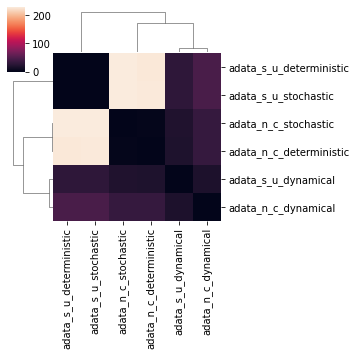

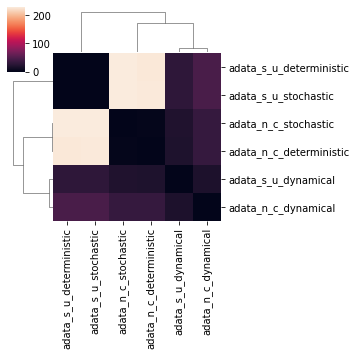

In [20]:
velo_mse_bygene=velocity_mean_mse(adata_dict,mode='by_gene')
sns.clustermap(velo_mse_bygene.astype(float),figsize=(5,5))
velo_mse_bycell=velocity_mean_mse(adata_dict,mode='by_cell')
sns.clustermap(velo_mse_bycell.astype(float),figsize=(5,5))

# Mean squared error of velocities (against reference)

In [21]:
velocity_mse_by_gene=velocity_mse_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_gene')
velocity_mse_by_cell=velocity_mse_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_cell')

Text(0, 0.5, 'Modality')

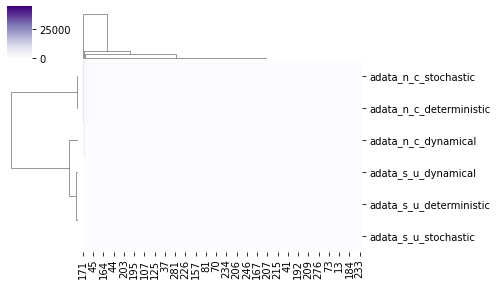

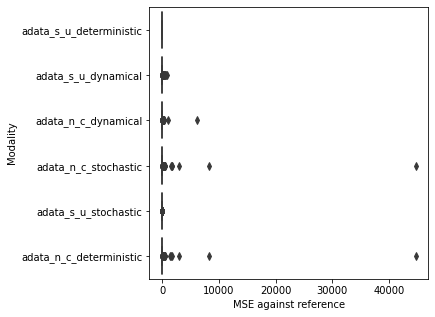

In [22]:
import matplotlib.pyplot as plt
sns.clustermap(velocity_mse_by_gene.fillna(0),figsize=(7,4),cmap='Purples')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_mse_by_gene.stack().reset_index(),y='level_0',x=0,palette='Purples')
plt.xlabel('MSE against reference')
plt.ylabel('Modality')


In [174]:
adata=adata_dict['adata_s_u_deterministic']

# Velocity sign

This code computes the accuracy of predicted velocity signs in gene expression data by comparing them to empirical velocity signs across multiple datasets. It outputs a DataFrame with the accuracy scores for each dataset, allowing evaluation of how well the models predict velocity dynamics. Modified from the VeloVI original study (Gayoso et al. 2023)

adata_s_u_deterministic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5793.91it/s]


adata_s_u_dynamical


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 4695.24it/s]


adata_n_c_dynamical


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 4697.53it/s]


adata_n_c_stochastic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5842.64it/s]


adata_s_u_stochastic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5790.87it/s]


adata_n_c_deterministic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5801.04it/s]


<Axes: xlabel='Accuracy', ylabel='Model'>

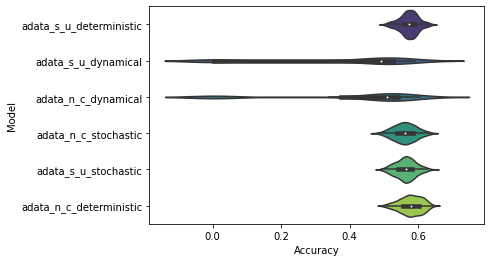

In [23]:
sign_accuracies=get_sign_accuracy(adata_dict)
sns.violinplot(data=sign_accuracies,y='Model',x='Accuracy',palette='viridis')

# Correlation of fitted times (only for dynamic)

In [137]:
corr_mat = np.corrcoef(
    adata_s_u.to_df("fit_t"), adata_n_c.to_df("fit_t"), rowvar=False
)
cross_corrs = np.diagonal(corr_mat[adata_n_c.shape[1] :, : adata.shape[1]])


In [138]:
corr_mat.shape

(500, 500)

<Axes: >

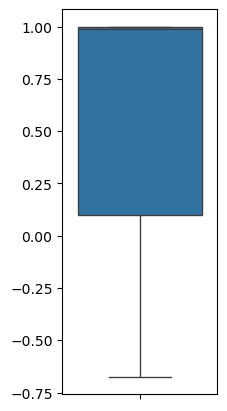

In [73]:
fig, ax = plt.subplots(figsize=(2, 5))
sns.boxplot(cross_corrs, ax= ax)

# Metrics - inferred velocity and latent time 

In [74]:
from scipy.stats import pearsonr, spearmanr, ttest_ind

In [98]:
for var_id in range(len(adata_s_u.var_names)):
    x = adata_s_u.layers["velocity"][:, var_id]

In [ ]:
corr_df_velocity = pd.DataFrame(columns=["EM", "VI"], index=np.arange(len(adata.var_names)))

for var_id in range(len(adata.var_names)):
    x = adata_s_u.layers["velocity"][:, var_id]
    y = adata_s_u.layers["true_velocity"][:, var_id]
    corr_df_velocity.loc[var_id, "EM"] = pearsonr(x, y)[0]

    x = adata_n_c.layers["velocity"][:, var_id]
    y = adata_n_c.layers["true_velocity"][:, var_id]
    corr_df_velocity.loc[var_id, "VI"] = pearsonr(x, y)[0]

corr_df_velocity['model'] = adata.var['model'].values